In [8]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


# MANGA Dataset
---

### Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [ ]:
# # Unzipping
# !unzip /content/drive/MyDrive/animeface-character-dataset.zip

In [6]:
!ls "$content/drive/My Drive"

ls: cannot access '$/content/drive/My Drive': No such file or directory


In [10]:
# Training and Validation data
transforms = v2.Compose([
    v2.Resize((64, 64)), # Resize to 224x224
    v2.ToTensor(),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), # Normalize
])

# Create Datasets for Training and Validation
PATH = '/content/animeface-character-dataset' # change path accordingly
train_dataset = ImageFolder(PATH, transform=transforms)

In [11]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 19508
    Root location: /content/animeface-character-dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [12]:
# Create a DataLoader for batching and shuffling the data
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Generator
---

In [30]:
class Generator(nn.Module):
    def __init__(self, maps = 64, noise_size = 128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(noise_size, maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.ReLU(True),
            # state size. (maps*8) x 4 x 4
            nn.ConvTranspose2d(maps * 8, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.ReLU(True),
            # state size. (maps*4) x 8 x 8
            nn.ConvTranspose2d(maps * 4, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.ReLU(True),
            # state size. (maps*2) x 16 x 16
            nn.ConvTranspose2d(maps * 2, maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps),
            nn.ReLU(True),
            # state size. (maps) x 32 x 32
            nn.ConvTranspose2d(maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

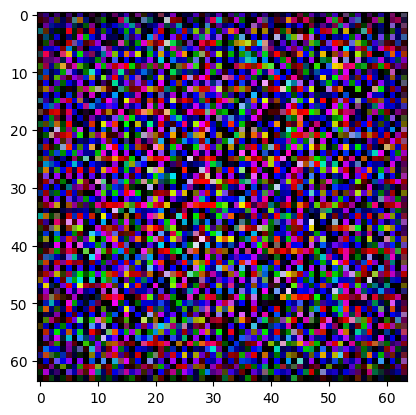

In [31]:
generator = Generator()
noise = torch.randn(64, 128, 1, 1)
output = generator(noise)
plt.imshow(output[0].detach().numpy().transpose(1, 2, 0))
plt.show()

# Discriminator
---

In [32]:
class Discriminator(nn.Module):
    def __init__(self, maps = 64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps) x 32 x 32
            nn.Conv2d(maps, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*2) x 16 x 16
            nn.Conv2d(maps * 2, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*4) x 8 x 8
            nn.Conv2d(maps * 4, maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*8) x 4 x 4
            nn.Conv2d(maps * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [33]:
# Instantiate the discriminator
discriminator = Discriminator()
output_discriminator = discriminator(output)
output_discriminator.shape

torch.Size([64, 1])

In [17]:
output.shape

torch.Size([64, 3, 64, 64])

# Training Loop
---

In [ ]:
# First time running the generator and discriminator

# generator = Generator()
# discriminator = Discriminator()

In [35]:
import pickle

# Read in the generator and discriminator saved after 50 epochs
with open('/content/drive/MyDrive/generator_100.pkl', 'rb') as f:
    generator = pickle.load(f)

with open('/content/drive/MyDrive/discriminator_100.pkl', 'rb') as f:
    discriminator = pickle.load(f)

In [36]:
##### Rashmi: I wasnt sure why the train loop was in the complier model class above so tried different way below
# since we have already defined gen and disc classes we can just initialize gen, disc, optimizers, and loss
# and then run the train loop

if torch.cuda.is_available():
    print("GPU is available")
    # Print GPU device name
    print("GPU device name:", torch.cuda.get_device_name(0))  # 0 is the index of the GPU
else:
    print("GPU is not available")

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)


# Training Loop
num_epochs = 100
latent_size = 128

for epoch in tqdm(range(num_epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train the generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Train the discriminator
        d_optimizer.zero_grad()
        real_outputs = discriminator(real_images)
        d_real_loss = criterion(real_outputs, real_labels)
        fake_outputs = discriminator(fake_images.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")


GPU is available
GPU device name: Tesla T4


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Step [100/610], Generator Loss: 6.8575, Discriminator Loss: 0.0434
Epoch [1/100], Step [200/610], Generator Loss: 7.3718, Discriminator Loss: 0.0110
Epoch [1/100], Step [300/610], Generator Loss: 2.1329, Discriminator Loss: 0.5717
Epoch [1/100], Step [400/610], Generator Loss: 8.3047, Discriminator Loss: 0.0065
Epoch [1/100], Step [500/610], Generator Loss: 5.6779, Discriminator Loss: 0.0365
Epoch [1/100], Step [600/610], Generator Loss: 7.2459, Discriminator Loss: 0.0220


  1%|          | 1/100 [00:42<1:09:38, 42.20s/it]

Epoch [2/100], Step [100/610], Generator Loss: 6.8124, Discriminator Loss: 0.0097
Epoch [2/100], Step [200/610], Generator Loss: 12.3477, Discriminator Loss: 0.1194
Epoch [2/100], Step [300/610], Generator Loss: 3.9243, Discriminator Loss: 0.1145
Epoch [2/100], Step [400/610], Generator Loss: 7.9287, Discriminator Loss: 0.0179
Epoch [2/100], Step [500/610], Generator Loss: 6.6542, Discriminator Loss: 0.0115
Epoch [2/100], Step [600/610], Generator Loss: 5.0398, Discriminator Loss: 0.0541


  2%|▏         | 2/100 [01:26<1:11:22, 43.70s/it]

Epoch [3/100], Step [100/610], Generator Loss: 6.4272, Discriminator Loss: 0.0205
Epoch [3/100], Step [200/610], Generator Loss: 7.5313, Discriminator Loss: 0.0049
Epoch [3/100], Step [300/610], Generator Loss: 7.3915, Discriminator Loss: 0.0094
Epoch [3/100], Step [400/610], Generator Loss: 9.1522, Discriminator Loss: 0.1163
Epoch [3/100], Step [500/610], Generator Loss: 5.3880, Discriminator Loss: 0.0672
Epoch [3/100], Step [600/610], Generator Loss: 9.8843, Discriminator Loss: 0.0081


  3%|▎         | 3/100 [02:10<1:10:43, 43.75s/it]

Epoch [4/100], Step [100/610], Generator Loss: 6.8475, Discriminator Loss: 0.0387
Epoch [4/100], Step [200/610], Generator Loss: 7.2265, Discriminator Loss: 0.0557
Epoch [4/100], Step [300/610], Generator Loss: 2.4949, Discriminator Loss: 0.8476
Epoch [4/100], Step [400/610], Generator Loss: 6.5766, Discriminator Loss: 0.0150
Epoch [4/100], Step [500/610], Generator Loss: 6.0588, Discriminator Loss: 0.0174
Epoch [4/100], Step [600/610], Generator Loss: 4.6983, Discriminator Loss: 0.0379


  4%|▍         | 4/100 [02:53<1:09:09, 43.23s/it]

Epoch [5/100], Step [100/610], Generator Loss: 7.5870, Discriminator Loss: 0.2354
Epoch [5/100], Step [200/610], Generator Loss: 6.8521, Discriminator Loss: 0.0060
Epoch [5/100], Step [300/610], Generator Loss: 5.0388, Discriminator Loss: 0.0758
Epoch [5/100], Step [400/610], Generator Loss: 6.7236, Discriminator Loss: 0.0117
Epoch [5/100], Step [500/610], Generator Loss: 8.4968, Discriminator Loss: 0.1221
Epoch [5/100], Step [600/610], Generator Loss: 4.2068, Discriminator Loss: 0.1046


  5%|▌         | 5/100 [03:37<1:08:55, 43.53s/it]

Epoch [6/100], Step [100/610], Generator Loss: 5.0579, Discriminator Loss: 0.0652
Epoch [6/100], Step [200/610], Generator Loss: 7.5323, Discriminator Loss: 0.0047
Epoch [6/100], Step [300/610], Generator Loss: 4.9036, Discriminator Loss: 0.1802
Epoch [6/100], Step [400/610], Generator Loss: 5.6591, Discriminator Loss: 0.0546
Epoch [6/100], Step [500/610], Generator Loss: 9.9180, Discriminator Loss: 0.3056
Epoch [6/100], Step [600/610], Generator Loss: 6.8970, Discriminator Loss: 0.0067


  6%|▌         | 6/100 [04:19<1:07:41, 43.21s/it]

Epoch [7/100], Step [100/610], Generator Loss: 6.3097, Discriminator Loss: 0.0142
Epoch [7/100], Step [200/610], Generator Loss: 4.7741, Discriminator Loss: 0.0714
Epoch [7/100], Step [300/610], Generator Loss: 6.1756, Discriminator Loss: 0.0480
Epoch [7/100], Step [400/610], Generator Loss: 5.1555, Discriminator Loss: 0.0431
Epoch [7/100], Step [500/610], Generator Loss: 7.6537, Discriminator Loss: 0.0110
Epoch [7/100], Step [600/610], Generator Loss: 7.5605, Discriminator Loss: 0.0271


  7%|▋         | 7/100 [05:02<1:06:37, 42.99s/it]

Epoch [8/100], Step [100/610], Generator Loss: 8.6365, Discriminator Loss: 0.0027
Epoch [8/100], Step [200/610], Generator Loss: 7.7868, Discriminator Loss: 0.0086
Epoch [8/100], Step [300/610], Generator Loss: 7.8529, Discriminator Loss: 0.0128
Epoch [8/100], Step [400/610], Generator Loss: 10.6415, Discriminator Loss: 0.0080
Epoch [8/100], Step [500/610], Generator Loss: 5.8662, Discriminator Loss: 0.0921
Epoch [8/100], Step [600/610], Generator Loss: 5.1683, Discriminator Loss: 0.0232


  8%|▊         | 8/100 [05:44<1:05:22, 42.63s/it]

Epoch [9/100], Step [100/610], Generator Loss: 6.7735, Discriminator Loss: 0.0106
Epoch [9/100], Step [200/610], Generator Loss: 6.1632, Discriminator Loss: 0.0292
Epoch [9/100], Step [300/610], Generator Loss: 8.4510, Discriminator Loss: 0.0073
Epoch [9/100], Step [400/610], Generator Loss: 7.4787, Discriminator Loss: 0.0232
Epoch [9/100], Step [500/610], Generator Loss: 4.7573, Discriminator Loss: 0.1046
Epoch [9/100], Step [600/610], Generator Loss: 8.8163, Discriminator Loss: 0.0197


  9%|▉         | 9/100 [06:27<1:05:01, 42.87s/it]

Epoch [10/100], Step [100/610], Generator Loss: 6.9690, Discriminator Loss: 0.0198
Epoch [10/100], Step [200/610], Generator Loss: 5.2048, Discriminator Loss: 0.0496
Epoch [10/100], Step [300/610], Generator Loss: 5.6977, Discriminator Loss: 0.0446
Epoch [10/100], Step [400/610], Generator Loss: 7.7790, Discriminator Loss: 0.0179
Epoch [10/100], Step [500/610], Generator Loss: 6.7090, Discriminator Loss: 0.0221
Epoch [10/100], Step [600/610], Generator Loss: 5.1874, Discriminator Loss: 0.0736


 10%|█         | 10/100 [07:09<1:03:52, 42.59s/it]

Epoch [11/100], Step [100/610], Generator Loss: 11.0547, Discriminator Loss: 0.0039
Epoch [11/100], Step [200/610], Generator Loss: 9.1457, Discriminator Loss: 0.0175
Epoch [11/100], Step [300/610], Generator Loss: 6.4715, Discriminator Loss: 0.0748
Epoch [11/100], Step [400/610], Generator Loss: 6.3718, Discriminator Loss: 0.0070
Epoch [11/100], Step [500/610], Generator Loss: 5.3162, Discriminator Loss: 0.0214
Epoch [11/100], Step [600/610], Generator Loss: 6.3588, Discriminator Loss: 0.0848


 11%|█         | 11/100 [07:51<1:02:50, 42.36s/it]

Epoch [12/100], Step [100/610], Generator Loss: 5.6848, Discriminator Loss: 0.0144
Epoch [12/100], Step [200/610], Generator Loss: 7.5198, Discriminator Loss: 0.0317
Epoch [12/100], Step [300/610], Generator Loss: 9.6338, Discriminator Loss: 0.0155
Epoch [12/100], Step [400/610], Generator Loss: 5.8152, Discriminator Loss: 0.0175
Epoch [12/100], Step [500/610], Generator Loss: 6.5855, Discriminator Loss: 0.0198
Epoch [12/100], Step [600/610], Generator Loss: 7.4018, Discriminator Loss: 0.0065


 12%|█▏        | 12/100 [08:35<1:03:02, 42.98s/it]

Epoch [13/100], Step [100/610], Generator Loss: 6.2652, Discriminator Loss: 0.0168
Epoch [13/100], Step [200/610], Generator Loss: 8.3801, Discriminator Loss: 0.0091
Epoch [13/100], Step [300/610], Generator Loss: 6.2126, Discriminator Loss: 0.0161
Epoch [13/100], Step [400/610], Generator Loss: 5.9983, Discriminator Loss: 0.0280
Epoch [13/100], Step [500/610], Generator Loss: 7.7496, Discriminator Loss: 0.0064
Epoch [13/100], Step [600/610], Generator Loss: 6.8651, Discriminator Loss: 0.0335


 13%|█▎        | 13/100 [09:17<1:01:56, 42.71s/it]

Epoch [14/100], Step [100/610], Generator Loss: 8.2765, Discriminator Loss: 0.0227
Epoch [14/100], Step [200/610], Generator Loss: 6.1683, Discriminator Loss: 0.0396
Epoch [14/100], Step [300/610], Generator Loss: 7.5437, Discriminator Loss: 0.0299
Epoch [14/100], Step [400/610], Generator Loss: 6.1844, Discriminator Loss: 0.0144
Epoch [14/100], Step [500/610], Generator Loss: 9.7467, Discriminator Loss: 0.1247
Epoch [14/100], Step [600/610], Generator Loss: 5.2912, Discriminator Loss: 0.0541


 14%|█▍        | 14/100 [10:00<1:00:58, 42.54s/it]

Epoch [15/100], Step [100/610], Generator Loss: 8.5372, Discriminator Loss: 0.1567
Epoch [15/100], Step [200/610], Generator Loss: 7.2296, Discriminator Loss: 0.0128
Epoch [15/100], Step [300/610], Generator Loss: 7.7515, Discriminator Loss: 0.0851
Epoch [15/100], Step [400/610], Generator Loss: 8.4662, Discriminator Loss: 0.0237
Epoch [15/100], Step [500/610], Generator Loss: 5.4081, Discriminator Loss: 0.0546
Epoch [15/100], Step [600/610], Generator Loss: 2.1010, Discriminator Loss: 3.4811


 15%|█▌        | 15/100 [10:43<1:00:33, 42.74s/it]

Epoch [16/100], Step [100/610], Generator Loss: 6.2608, Discriminator Loss: 0.0095
Epoch [16/100], Step [200/610], Generator Loss: 6.0084, Discriminator Loss: 0.0764
Epoch [16/100], Step [300/610], Generator Loss: 6.7402, Discriminator Loss: 0.0225
Epoch [16/100], Step [400/610], Generator Loss: 5.7264, Discriminator Loss: 0.0316
Epoch [16/100], Step [500/610], Generator Loss: 9.3808, Discriminator Loss: 0.0266
Epoch [16/100], Step [600/610], Generator Loss: 9.2767, Discriminator Loss: 0.0010


 16%|█▌        | 16/100 [11:25<59:38, 42.61s/it]  

Epoch [17/100], Step [100/610], Generator Loss: 5.3271, Discriminator Loss: 0.0364
Epoch [17/100], Step [200/610], Generator Loss: 8.8750, Discriminator Loss: 0.0382
Epoch [17/100], Step [300/610], Generator Loss: 5.5953, Discriminator Loss: 0.0664
Epoch [17/100], Step [400/610], Generator Loss: 9.6049, Discriminator Loss: 0.1882
Epoch [17/100], Step [500/610], Generator Loss: 4.4059, Discriminator Loss: 0.1867
Epoch [17/100], Step [600/610], Generator Loss: 6.8643, Discriminator Loss: 0.0358


 17%|█▋        | 17/100 [12:07<58:47, 42.50s/it]

Epoch [18/100], Step [100/610], Generator Loss: 7.7029, Discriminator Loss: 0.0220
Epoch [18/100], Step [200/610], Generator Loss: 7.7648, Discriminator Loss: 0.0070
Epoch [18/100], Step [300/610], Generator Loss: 7.0692, Discriminator Loss: 0.0257
Epoch [18/100], Step [400/610], Generator Loss: 7.8082, Discriminator Loss: 0.0190
Epoch [18/100], Step [500/610], Generator Loss: 7.4252, Discriminator Loss: 0.0173
Epoch [18/100], Step [600/610], Generator Loss: 7.0801, Discriminator Loss: 0.0034


 18%|█▊        | 18/100 [12:51<58:40, 42.94s/it]

Epoch [19/100], Step [100/610], Generator Loss: 6.4440, Discriminator Loss: 0.0246
Epoch [19/100], Step [200/610], Generator Loss: 6.0699, Discriminator Loss: 0.0253
Epoch [19/100], Step [300/610], Generator Loss: 5.0338, Discriminator Loss: 0.1308
Epoch [19/100], Step [400/610], Generator Loss: 6.9265, Discriminator Loss: 0.0137
Epoch [19/100], Step [500/610], Generator Loss: 7.4485, Discriminator Loss: 0.0086
Epoch [19/100], Step [600/610], Generator Loss: 9.1355, Discriminator Loss: 0.0066


 19%|█▉        | 19/100 [13:35<58:08, 43.07s/it]

Epoch [20/100], Step [100/610], Generator Loss: 5.2414, Discriminator Loss: 0.0752
Epoch [20/100], Step [200/610], Generator Loss: 6.3819, Discriminator Loss: 0.0134
Epoch [20/100], Step [300/610], Generator Loss: 8.3264, Discriminator Loss: 0.0249
Epoch [20/100], Step [400/610], Generator Loss: 6.5504, Discriminator Loss: 0.0310
Epoch [20/100], Step [500/610], Generator Loss: 4.3025, Discriminator Loss: 0.0828
Epoch [20/100], Step [600/610], Generator Loss: 5.4210, Discriminator Loss: 0.1044


 20%|██        | 20/100 [14:17<57:17, 42.97s/it]

Epoch [21/100], Step [100/610], Generator Loss: 5.7494, Discriminator Loss: 0.0417
Epoch [21/100], Step [200/610], Generator Loss: 9.4733, Discriminator Loss: 0.0084
Epoch [21/100], Step [300/610], Generator Loss: 5.7266, Discriminator Loss: 0.0559
Epoch [21/100], Step [400/610], Generator Loss: 8.2390, Discriminator Loss: 0.0111
Epoch [21/100], Step [500/610], Generator Loss: 9.0957, Discriminator Loss: 0.0285
Epoch [21/100], Step [600/610], Generator Loss: 4.1963, Discriminator Loss: 0.1115


 21%|██        | 21/100 [15:01<57:01, 43.31s/it]

Epoch [22/100], Step [100/610], Generator Loss: 3.6610, Discriminator Loss: 0.2385
Epoch [22/100], Step [200/610], Generator Loss: 11.3216, Discriminator Loss: 0.0577
Epoch [22/100], Step [300/610], Generator Loss: 5.6309, Discriminator Loss: 0.0151
Epoch [22/100], Step [400/610], Generator Loss: 6.2993, Discriminator Loss: 0.0164
Epoch [22/100], Step [500/610], Generator Loss: 6.6452, Discriminator Loss: 0.0177
Epoch [22/100], Step [600/610], Generator Loss: 5.7962, Discriminator Loss: 0.0244


 22%|██▏       | 22/100 [15:44<55:56, 43.03s/it]

Epoch [23/100], Step [100/610], Generator Loss: 5.2450, Discriminator Loss: 0.1133
Epoch [23/100], Step [200/610], Generator Loss: 8.1926, Discriminator Loss: 0.0182
Epoch [23/100], Step [300/610], Generator Loss: 7.1120, Discriminator Loss: 0.0359
Epoch [23/100], Step [400/610], Generator Loss: 5.1762, Discriminator Loss: 0.0385
Epoch [23/100], Step [500/610], Generator Loss: 7.8060, Discriminator Loss: 0.0025
Epoch [23/100], Step [600/610], Generator Loss: 4.8782, Discriminator Loss: 0.1828


 23%|██▎       | 23/100 [16:26<55:03, 42.91s/it]

Epoch [24/100], Step [100/610], Generator Loss: 6.3974, Discriminator Loss: 0.0315
Epoch [24/100], Step [200/610], Generator Loss: 7.9847, Discriminator Loss: 0.0294
Epoch [24/100], Step [300/610], Generator Loss: 7.5679, Discriminator Loss: 0.0068
Epoch [24/100], Step [400/610], Generator Loss: 8.3150, Discriminator Loss: 0.0052
Epoch [24/100], Step [500/610], Generator Loss: 7.7559, Discriminator Loss: 0.0029
Epoch [24/100], Step [600/610], Generator Loss: 10.4055, Discriminator Loss: 0.0353


 24%|██▍       | 24/100 [17:11<54:48, 43.27s/it]

Epoch [25/100], Step [100/610], Generator Loss: 8.7189, Discriminator Loss: 0.2200
Epoch [25/100], Step [200/610], Generator Loss: 5.3786, Discriminator Loss: 0.0191
Epoch [25/100], Step [300/610], Generator Loss: 7.9460, Discriminator Loss: 0.0298
Epoch [25/100], Step [400/610], Generator Loss: 7.1431, Discriminator Loss: 0.1255
Epoch [25/100], Step [500/610], Generator Loss: 4.8649, Discriminator Loss: 0.0599
Epoch [25/100], Step [600/610], Generator Loss: 7.6673, Discriminator Loss: 0.0063


 25%|██▌       | 25/100 [17:53<53:56, 43.15s/it]

Epoch [26/100], Step [100/610], Generator Loss: 6.6506, Discriminator Loss: 0.0108
Epoch [26/100], Step [200/610], Generator Loss: 12.2978, Discriminator Loss: 0.0068
Epoch [26/100], Step [300/610], Generator Loss: 9.2294, Discriminator Loss: 0.0024
Epoch [26/100], Step [400/610], Generator Loss: 7.2596, Discriminator Loss: 0.0060
Epoch [26/100], Step [500/610], Generator Loss: 3.3396, Discriminator Loss: 1.0482
Epoch [26/100], Step [600/610], Generator Loss: 10.0363, Discriminator Loss: 0.0016


 26%|██▌       | 26/100 [18:36<53:08, 43.09s/it]

Epoch [27/100], Step [100/610], Generator Loss: 6.3730, Discriminator Loss: 0.0195
Epoch [27/100], Step [200/610], Generator Loss: 7.5147, Discriminator Loss: 0.0129
Epoch [27/100], Step [300/610], Generator Loss: 8.0859, Discriminator Loss: 0.0056
Epoch [27/100], Step [400/610], Generator Loss: 7.2614, Discriminator Loss: 0.0233
Epoch [27/100], Step [500/610], Generator Loss: 10.1745, Discriminator Loss: 0.0660
Epoch [27/100], Step [600/610], Generator Loss: 11.0232, Discriminator Loss: 0.0651


 27%|██▋       | 27/100 [19:20<52:35, 43.22s/it]

Epoch [28/100], Step [100/610], Generator Loss: 4.2048, Discriminator Loss: 0.4550
Epoch [28/100], Step [200/610], Generator Loss: 4.8534, Discriminator Loss: 0.0483
Epoch [28/100], Step [300/610], Generator Loss: 7.6768, Discriminator Loss: 0.0117
Epoch [28/100], Step [400/610], Generator Loss: 6.9269, Discriminator Loss: 0.0859
Epoch [28/100], Step [500/610], Generator Loss: 5.6668, Discriminator Loss: 0.0450
Epoch [28/100], Step [600/610], Generator Loss: 8.7231, Discriminator Loss: 0.0046


 28%|██▊       | 28/100 [20:02<51:24, 42.84s/it]

Epoch [29/100], Step [100/610], Generator Loss: 8.3086, Discriminator Loss: 0.0261
Epoch [29/100], Step [200/610], Generator Loss: 8.0844, Discriminator Loss: 0.0037
Epoch [29/100], Step [300/610], Generator Loss: 8.1797, Discriminator Loss: 0.0142
Epoch [29/100], Step [400/610], Generator Loss: 3.5892, Discriminator Loss: 0.3759
Epoch [29/100], Step [500/610], Generator Loss: 7.8202, Discriminator Loss: 0.0382
Epoch [29/100], Step [600/610], Generator Loss: 6.8456, Discriminator Loss: 0.0906


 29%|██▉       | 29/100 [20:43<50:12, 42.42s/it]

Epoch [30/100], Step [100/610], Generator Loss: 6.9388, Discriminator Loss: 0.0130
Epoch [30/100], Step [200/610], Generator Loss: 6.9414, Discriminator Loss: 0.0035
Epoch [30/100], Step [300/610], Generator Loss: 9.6789, Discriminator Loss: 0.0125
Epoch [30/100], Step [400/610], Generator Loss: 7.4029, Discriminator Loss: 0.0061
Epoch [30/100], Step [500/610], Generator Loss: 7.1899, Discriminator Loss: 0.0189
Epoch [30/100], Step [600/610], Generator Loss: 8.6441, Discriminator Loss: 0.0132


 30%|███       | 30/100 [21:29<50:47, 43.53s/it]

Epoch [31/100], Step [100/610], Generator Loss: 9.4741, Discriminator Loss: 0.1106
Epoch [31/100], Step [200/610], Generator Loss: 8.7091, Discriminator Loss: 0.0193
Epoch [31/100], Step [300/610], Generator Loss: 6.3723, Discriminator Loss: 0.0134
Epoch [31/100], Step [400/610], Generator Loss: 9.4785, Discriminator Loss: 0.0033
Epoch [31/100], Step [500/610], Generator Loss: 8.1227, Discriminator Loss: 0.0096
Epoch [31/100], Step [600/610], Generator Loss: 7.5300, Discriminator Loss: 0.0071


 31%|███       | 31/100 [22:12<49:42, 43.22s/it]

Epoch [32/100], Step [100/610], Generator Loss: 4.8546, Discriminator Loss: 0.1168
Epoch [32/100], Step [200/610], Generator Loss: 7.1615, Discriminator Loss: 0.0397
Epoch [32/100], Step [300/610], Generator Loss: 4.6786, Discriminator Loss: 0.0437
Epoch [32/100], Step [400/610], Generator Loss: 8.1069, Discriminator Loss: 0.0202
Epoch [32/100], Step [500/610], Generator Loss: 6.9753, Discriminator Loss: 0.0228
Epoch [32/100], Step [600/610], Generator Loss: 8.1531, Discriminator Loss: 0.0297


 32%|███▏      | 32/100 [22:55<48:57, 43.20s/it]

Epoch [33/100], Step [100/610], Generator Loss: 7.8191, Discriminator Loss: 0.0092
Epoch [33/100], Step [200/610], Generator Loss: 9.1570, Discriminator Loss: 0.0369
Epoch [33/100], Step [300/610], Generator Loss: 8.1400, Discriminator Loss: 0.0226
Epoch [33/100], Step [400/610], Generator Loss: 6.7193, Discriminator Loss: 0.0518
Epoch [33/100], Step [500/610], Generator Loss: 7.3944, Discriminator Loss: 0.0335
Epoch [33/100], Step [600/610], Generator Loss: 9.0642, Discriminator Loss: 0.0057


 33%|███▎      | 33/100 [23:39<48:20, 43.29s/it]

Epoch [34/100], Step [100/610], Generator Loss: 5.9249, Discriminator Loss: 0.0122
Epoch [34/100], Step [200/610], Generator Loss: 3.5800, Discriminator Loss: 0.1873
Epoch [34/100], Step [300/610], Generator Loss: 9.3121, Discriminator Loss: 0.0019
Epoch [34/100], Step [400/610], Generator Loss: 6.8234, Discriminator Loss: 0.0414
Epoch [34/100], Step [500/610], Generator Loss: 8.3173, Discriminator Loss: 0.0741
Epoch [34/100], Step [600/610], Generator Loss: 13.3215, Discriminator Loss: 0.3662


 34%|███▍      | 34/100 [24:22<47:48, 43.46s/it]

Epoch [35/100], Step [100/610], Generator Loss: 5.3672, Discriminator Loss: 0.1181
Epoch [35/100], Step [200/610], Generator Loss: 7.1665, Discriminator Loss: 0.0200
Epoch [35/100], Step [300/610], Generator Loss: 6.0452, Discriminator Loss: 0.0199
Epoch [35/100], Step [400/610], Generator Loss: 8.1495, Discriminator Loss: 0.1434
Epoch [35/100], Step [500/610], Generator Loss: 7.3483, Discriminator Loss: 0.1019
Epoch [35/100], Step [600/610], Generator Loss: 6.6252, Discriminator Loss: 0.0246


 35%|███▌      | 35/100 [25:05<46:51, 43.26s/it]

Epoch [36/100], Step [100/610], Generator Loss: 7.4774, Discriminator Loss: 0.0332
Epoch [36/100], Step [200/610], Generator Loss: 13.0536, Discriminator Loss: 0.1054
Epoch [36/100], Step [300/610], Generator Loss: 8.2173, Discriminator Loss: 0.0028
Epoch [36/100], Step [400/610], Generator Loss: 8.5889, Discriminator Loss: 0.0028
Epoch [36/100], Step [500/610], Generator Loss: 6.2490, Discriminator Loss: 0.0206
Epoch [36/100], Step [600/610], Generator Loss: 8.3827, Discriminator Loss: 0.0280


 36%|███▌      | 36/100 [25:48<45:56, 43.08s/it]

Epoch [37/100], Step [100/610], Generator Loss: 10.2815, Discriminator Loss: 0.0111
Epoch [37/100], Step [200/610], Generator Loss: 5.8320, Discriminator Loss: 0.0477
Epoch [37/100], Step [300/610], Generator Loss: 9.2423, Discriminator Loss: 0.0068
Epoch [37/100], Step [400/610], Generator Loss: 6.4803, Discriminator Loss: 0.0186
Epoch [37/100], Step [500/610], Generator Loss: 8.8001, Discriminator Loss: 0.0717
Epoch [37/100], Step [600/610], Generator Loss: 7.8086, Discriminator Loss: 0.0218


 37%|███▋      | 37/100 [26:34<46:05, 43.89s/it]

Epoch [38/100], Step [100/610], Generator Loss: 8.4175, Discriminator Loss: 0.0098
Epoch [38/100], Step [200/610], Generator Loss: 7.4678, Discriminator Loss: 0.0076
Epoch [38/100], Step [300/610], Generator Loss: 5.7886, Discriminator Loss: 0.0245
Epoch [38/100], Step [400/610], Generator Loss: 7.8178, Discriminator Loss: 0.0111
Epoch [38/100], Step [500/610], Generator Loss: 7.2402, Discriminator Loss: 0.0253
Epoch [38/100], Step [600/610], Generator Loss: 7.4113, Discriminator Loss: 0.0026


 38%|███▊      | 38/100 [27:16<45:00, 43.55s/it]

Epoch [39/100], Step [100/610], Generator Loss: 6.7572, Discriminator Loss: 0.0043
Epoch [39/100], Step [200/610], Generator Loss: 6.5001, Discriminator Loss: 0.0190
Epoch [39/100], Step [300/610], Generator Loss: 8.4105, Discriminator Loss: 0.0015
Epoch [39/100], Step [400/610], Generator Loss: 7.2922, Discriminator Loss: 0.0121
Epoch [39/100], Step [500/610], Generator Loss: 0.1170, Discriminator Loss: 5.9292
Epoch [39/100], Step [600/610], Generator Loss: 8.0993, Discriminator Loss: 0.0056


 39%|███▉      | 39/100 [28:02<44:47, 44.06s/it]

Epoch [40/100], Step [100/610], Generator Loss: 7.4962, Discriminator Loss: 0.0051
Epoch [40/100], Step [200/610], Generator Loss: 7.8481, Discriminator Loss: 0.0070
Epoch [40/100], Step [300/610], Generator Loss: 10.3263, Discriminator Loss: 0.4346
Epoch [40/100], Step [400/610], Generator Loss: 4.8362, Discriminator Loss: 0.0405
Epoch [40/100], Step [500/610], Generator Loss: 8.7235, Discriminator Loss: 0.0034
Epoch [40/100], Step [600/610], Generator Loss: 12.5726, Discriminator Loss: 0.0302


 40%|████      | 40/100 [28:46<44:04, 44.07s/it]

Epoch [41/100], Step [100/610], Generator Loss: 7.2521, Discriminator Loss: 0.0172
Epoch [41/100], Step [200/610], Generator Loss: 7.2043, Discriminator Loss: 0.0188
Epoch [41/100], Step [300/610], Generator Loss: 7.9766, Discriminator Loss: 0.0026
Epoch [41/100], Step [400/610], Generator Loss: 7.4076, Discriminator Loss: 0.0259
Epoch [41/100], Step [500/610], Generator Loss: 8.3169, Discriminator Loss: 0.0112
Epoch [41/100], Step [600/610], Generator Loss: 8.1077, Discriminator Loss: 0.0200


 41%|████      | 41/100 [29:28<42:50, 43.56s/it]

Epoch [42/100], Step [100/610], Generator Loss: 8.5291, Discriminator Loss: 0.0114
Epoch [42/100], Step [200/610], Generator Loss: 9.3904, Discriminator Loss: 0.0036
Epoch [42/100], Step [300/610], Generator Loss: 8.6573, Discriminator Loss: 0.0024
Epoch [42/100], Step [400/610], Generator Loss: 6.6401, Discriminator Loss: 0.0205
Epoch [42/100], Step [500/610], Generator Loss: 5.9029, Discriminator Loss: 0.0125
Epoch [42/100], Step [600/610], Generator Loss: 8.2086, Discriminator Loss: 0.0181


 42%|████▏     | 42/100 [30:11<41:49, 43.26s/it]

Epoch [43/100], Step [100/610], Generator Loss: 6.6979, Discriminator Loss: 0.0508
Epoch [43/100], Step [200/610], Generator Loss: 5.5781, Discriminator Loss: 0.0180
Epoch [43/100], Step [300/610], Generator Loss: 7.0202, Discriminator Loss: 0.0076
Epoch [43/100], Step [400/610], Generator Loss: 7.1898, Discriminator Loss: 0.0058
Epoch [43/100], Step [500/610], Generator Loss: 13.0652, Discriminator Loss: 0.0028
Epoch [43/100], Step [600/610], Generator Loss: 6.6859, Discriminator Loss: 0.0167


 43%|████▎     | 43/100 [30:55<41:17, 43.46s/it]

Epoch [44/100], Step [100/610], Generator Loss: 6.9227, Discriminator Loss: 0.0366
Epoch [44/100], Step [200/610], Generator Loss: 3.2951, Discriminator Loss: 0.2847
Epoch [44/100], Step [300/610], Generator Loss: 6.1177, Discriminator Loss: 0.0121
Epoch [44/100], Step [400/610], Generator Loss: 4.7977, Discriminator Loss: 0.0385
Epoch [44/100], Step [500/610], Generator Loss: 7.3712, Discriminator Loss: 0.0204
Epoch [44/100], Step [600/610], Generator Loss: 7.9214, Discriminator Loss: 0.0064


 44%|████▍     | 44/100 [31:38<40:24, 43.29s/it]

Epoch [45/100], Step [100/610], Generator Loss: 11.8046, Discriminator Loss: 0.0067
Epoch [45/100], Step [200/610], Generator Loss: 7.5953, Discriminator Loss: 0.0104
Epoch [45/100], Step [300/610], Generator Loss: 7.2735, Discriminator Loss: 0.0151
Epoch [45/100], Step [400/610], Generator Loss: 8.9498, Discriminator Loss: 0.0033
Epoch [45/100], Step [500/610], Generator Loss: 8.7708, Discriminator Loss: 0.0043
Epoch [45/100], Step [600/610], Generator Loss: 9.1721, Discriminator Loss: 0.0052


 45%|████▌     | 45/100 [32:20<39:25, 43.02s/it]

Epoch [46/100], Step [100/610], Generator Loss: 10.1143, Discriminator Loss: 0.0218
Epoch [46/100], Step [200/610], Generator Loss: 8.2313, Discriminator Loss: 0.0086
Epoch [46/100], Step [300/610], Generator Loss: 7.2868, Discriminator Loss: 0.0163
Epoch [46/100], Step [400/610], Generator Loss: 7.4440, Discriminator Loss: 0.0057
Epoch [46/100], Step [500/610], Generator Loss: 9.0029, Discriminator Loss: 0.0979
Epoch [46/100], Step [600/610], Generator Loss: 7.3232, Discriminator Loss: 0.0585


 46%|████▌     | 46/100 [33:03<38:51, 43.17s/it]

Epoch [47/100], Step [100/610], Generator Loss: 6.5062, Discriminator Loss: 0.0135
Epoch [47/100], Step [200/610], Generator Loss: 9.8608, Discriminator Loss: 0.0747
Epoch [47/100], Step [300/610], Generator Loss: 8.5196, Discriminator Loss: 0.0208
Epoch [47/100], Step [400/610], Generator Loss: 5.4938, Discriminator Loss: 0.0793
Epoch [47/100], Step [500/610], Generator Loss: 8.4037, Discriminator Loss: 0.0123
Epoch [47/100], Step [600/610], Generator Loss: 6.9102, Discriminator Loss: 0.0145


 47%|████▋     | 47/100 [33:46<37:54, 42.92s/it]

Epoch [48/100], Step [100/610], Generator Loss: 9.3415, Discriminator Loss: 0.0103
Epoch [48/100], Step [200/610], Generator Loss: 4.8060, Discriminator Loss: 0.0610
Epoch [48/100], Step [300/610], Generator Loss: 7.7172, Discriminator Loss: 0.0366
Epoch [48/100], Step [400/610], Generator Loss: 8.5288, Discriminator Loss: 0.0038
Epoch [48/100], Step [500/610], Generator Loss: 9.7388, Discriminator Loss: 0.0221
Epoch [48/100], Step [600/610], Generator Loss: 9.5517, Discriminator Loss: 0.0375


 48%|████▊     | 48/100 [34:28<37:06, 42.82s/it]

Epoch [49/100], Step [100/610], Generator Loss: 5.7629, Discriminator Loss: 0.0256
Epoch [49/100], Step [200/610], Generator Loss: 5.3256, Discriminator Loss: 0.0269
Epoch [49/100], Step [300/610], Generator Loss: 7.3290, Discriminator Loss: 0.0051
Epoch [49/100], Step [400/610], Generator Loss: 6.7345, Discriminator Loss: 0.0166
Epoch [49/100], Step [500/610], Generator Loss: 7.4346, Discriminator Loss: 0.0245
Epoch [49/100], Step [600/610], Generator Loss: 8.3712, Discriminator Loss: 0.0070


 49%|████▉     | 49/100 [35:13<36:45, 43.24s/it]

Epoch [50/100], Step [100/610], Generator Loss: 6.1390, Discriminator Loss: 0.0375
Epoch [50/100], Step [200/610], Generator Loss: 7.3361, Discriminator Loss: 0.0496
Epoch [50/100], Step [300/610], Generator Loss: 7.3290, Discriminator Loss: 0.0092
Epoch [50/100], Step [400/610], Generator Loss: 9.6330, Discriminator Loss: 0.0221
Epoch [50/100], Step [500/610], Generator Loss: 7.4434, Discriminator Loss: 0.0071
Epoch [50/100], Step [600/610], Generator Loss: 6.0614, Discriminator Loss: 0.0565


 50%|█████     | 50/100 [35:55<35:56, 43.13s/it]

Epoch [51/100], Step [100/610], Generator Loss: 9.2984, Discriminator Loss: 0.0071
Epoch [51/100], Step [200/610], Generator Loss: 8.5766, Discriminator Loss: 0.0137
Epoch [51/100], Step [300/610], Generator Loss: 7.0691, Discriminator Loss: 0.0079
Epoch [51/100], Step [400/610], Generator Loss: 7.2738, Discriminator Loss: 0.0038
Epoch [51/100], Step [500/610], Generator Loss: 7.9836, Discriminator Loss: 0.0066
Epoch [51/100], Step [600/610], Generator Loss: 6.0898, Discriminator Loss: 0.1534


 51%|█████     | 51/100 [36:38<35:01, 42.89s/it]

Epoch [52/100], Step [100/610], Generator Loss: 7.6439, Discriminator Loss: 0.0151
Epoch [52/100], Step [200/610], Generator Loss: 6.9089, Discriminator Loss: 0.0146
Epoch [52/100], Step [300/610], Generator Loss: 8.6328, Discriminator Loss: 0.0017
Epoch [52/100], Step [400/610], Generator Loss: 5.9544, Discriminator Loss: 0.0290
Epoch [52/100], Step [500/610], Generator Loss: 6.0114, Discriminator Loss: 0.0089
Epoch [52/100], Step [600/610], Generator Loss: 7.8281, Discriminator Loss: 0.0121


 52%|█████▏    | 52/100 [37:20<34:10, 42.73s/it]

Epoch [53/100], Step [100/610], Generator Loss: 8.1429, Discriminator Loss: 0.0065
Epoch [53/100], Step [200/610], Generator Loss: 6.4183, Discriminator Loss: 0.0506
Epoch [53/100], Step [300/610], Generator Loss: 8.7518, Discriminator Loss: 0.0661
Epoch [53/100], Step [400/610], Generator Loss: 8.3612, Discriminator Loss: 0.0125
Epoch [53/100], Step [500/610], Generator Loss: 7.2313, Discriminator Loss: 0.0063
Epoch [53/100], Step [600/610], Generator Loss: 9.1834, Discriminator Loss: 0.0351


 53%|█████▎    | 53/100 [38:04<33:45, 43.09s/it]

Epoch [54/100], Step [100/610], Generator Loss: 8.3881, Discriminator Loss: 0.0065
Epoch [54/100], Step [200/610], Generator Loss: 9.5986, Discriminator Loss: 0.0020
Epoch [54/100], Step [300/610], Generator Loss: 6.9860, Discriminator Loss: 0.0082
Epoch [54/100], Step [400/610], Generator Loss: 6.8099, Discriminator Loss: 0.0094
Epoch [54/100], Step [500/610], Generator Loss: 7.8111, Discriminator Loss: 0.0078
Epoch [54/100], Step [600/610], Generator Loss: 8.1527, Discriminator Loss: 0.0482


 54%|█████▍    | 54/100 [38:46<32:51, 42.87s/it]

Epoch [55/100], Step [100/610], Generator Loss: 7.5921, Discriminator Loss: 0.0086
Epoch [55/100], Step [200/610], Generator Loss: 6.9732, Discriminator Loss: 0.0157
Epoch [55/100], Step [300/610], Generator Loss: 7.8261, Discriminator Loss: 0.0057
Epoch [55/100], Step [400/610], Generator Loss: 6.8722, Discriminator Loss: 0.2142
Epoch [55/100], Step [500/610], Generator Loss: 5.9581, Discriminator Loss: 0.0200
Epoch [55/100], Step [600/610], Generator Loss: 14.2814, Discriminator Loss: 0.0026


 55%|█████▌    | 55/100 [39:29<32:05, 42.79s/it]

Epoch [56/100], Step [100/610], Generator Loss: 7.3910, Discriminator Loss: 0.0093
Epoch [56/100], Step [200/610], Generator Loss: 5.7877, Discriminator Loss: 0.0109
Epoch [56/100], Step [300/610], Generator Loss: 6.8418, Discriminator Loss: 0.0281
Epoch [56/100], Step [400/610], Generator Loss: 7.2958, Discriminator Loss: 0.0092
Epoch [56/100], Step [500/610], Generator Loss: 9.1639, Discriminator Loss: 0.0135
Epoch [56/100], Step [600/610], Generator Loss: 6.5849, Discriminator Loss: 0.0572


 56%|█████▌    | 56/100 [40:14<31:46, 43.32s/it]

Epoch [57/100], Step [100/610], Generator Loss: 7.0867, Discriminator Loss: 0.0085
Epoch [57/100], Step [200/610], Generator Loss: 9.0702, Discriminator Loss: 0.2056
Epoch [57/100], Step [300/610], Generator Loss: 8.4061, Discriminator Loss: 0.0183
Epoch [57/100], Step [400/610], Generator Loss: 6.2167, Discriminator Loss: 0.0267
Epoch [57/100], Step [500/610], Generator Loss: 8.4551, Discriminator Loss: 0.0077
Epoch [57/100], Step [600/610], Generator Loss: 8.8289, Discriminator Loss: 0.0126


 57%|█████▋    | 57/100 [40:58<31:13, 43.58s/it]

Epoch [58/100], Step [100/610], Generator Loss: 7.4060, Discriminator Loss: 0.0023
Epoch [58/100], Step [200/610], Generator Loss: 6.8183, Discriminator Loss: 0.0467
Epoch [58/100], Step [300/610], Generator Loss: 8.9246, Discriminator Loss: 0.0205
Epoch [58/100], Step [400/610], Generator Loss: 8.9173, Discriminator Loss: 0.0010
Epoch [58/100], Step [500/610], Generator Loss: 10.0523, Discriminator Loss: 0.0123
Epoch [58/100], Step [600/610], Generator Loss: 6.4376, Discriminator Loss: 0.0444


 58%|█████▊    | 58/100 [41:43<30:53, 44.13s/it]

Epoch [59/100], Step [100/610], Generator Loss: 5.5563, Discriminator Loss: 0.2377
Epoch [59/100], Step [200/610], Generator Loss: 10.1835, Discriminator Loss: 0.0013
Epoch [59/100], Step [300/610], Generator Loss: 11.9611, Discriminator Loss: 0.0044
Epoch [59/100], Step [400/610], Generator Loss: 7.2616, Discriminator Loss: 0.0123
Epoch [59/100], Step [500/610], Generator Loss: 6.1691, Discriminator Loss: 0.0280
Epoch [59/100], Step [600/610], Generator Loss: 7.0179, Discriminator Loss: 0.0063


 59%|█████▉    | 59/100 [42:30<30:36, 44.79s/it]

Epoch [60/100], Step [100/610], Generator Loss: 7.4823, Discriminator Loss: 0.0183
Epoch [60/100], Step [200/610], Generator Loss: 9.1456, Discriminator Loss: 0.0027
Epoch [60/100], Step [300/610], Generator Loss: 12.6952, Discriminator Loss: 0.0197
Epoch [60/100], Step [400/610], Generator Loss: 7.5191, Discriminator Loss: 0.0115
Epoch [60/100], Step [500/610], Generator Loss: 8.0511, Discriminator Loss: 0.0027
Epoch [60/100], Step [600/610], Generator Loss: 15.2744, Discriminator Loss: 0.0064


 60%|██████    | 60/100 [43:15<29:58, 44.95s/it]

Epoch [61/100], Step [100/610], Generator Loss: 7.1793, Discriminator Loss: 0.0509
Epoch [61/100], Step [200/610], Generator Loss: 9.1621, Discriminator Loss: 0.0236
Epoch [61/100], Step [300/610], Generator Loss: 11.8151, Discriminator Loss: 0.0256
Epoch [61/100], Step [400/610], Generator Loss: 12.3810, Discriminator Loss: 0.1597
Epoch [61/100], Step [500/610], Generator Loss: 9.4219, Discriminator Loss: 0.0080
Epoch [61/100], Step [600/610], Generator Loss: 7.5139, Discriminator Loss: 0.0210


 61%|██████    | 61/100 [44:02<29:42, 45.70s/it]

Epoch [62/100], Step [100/610], Generator Loss: 7.4470, Discriminator Loss: 0.0333
Epoch [62/100], Step [200/610], Generator Loss: 7.5390, Discriminator Loss: 0.0185
Epoch [62/100], Step [300/610], Generator Loss: 10.1502, Discriminator Loss: 0.0715
Epoch [62/100], Step [400/610], Generator Loss: 7.1556, Discriminator Loss: 0.0295
Epoch [62/100], Step [500/610], Generator Loss: 8.5918, Discriminator Loss: 0.0055
Epoch [62/100], Step [600/610], Generator Loss: 7.0494, Discriminator Loss: 0.0234


 62%|██████▏   | 62/100 [44:47<28:50, 45.53s/it]

Epoch [63/100], Step [100/610], Generator Loss: 7.6909, Discriminator Loss: 0.0150
Epoch [63/100], Step [200/610], Generator Loss: 11.4582, Discriminator Loss: 0.0854
Epoch [63/100], Step [300/610], Generator Loss: 10.7397, Discriminator Loss: 0.0316
Epoch [63/100], Step [400/610], Generator Loss: 9.4170, Discriminator Loss: 0.0158
Epoch [63/100], Step [500/610], Generator Loss: 11.3342, Discriminator Loss: 0.2234
Epoch [63/100], Step [600/610], Generator Loss: 7.8603, Discriminator Loss: 0.0026


 63%|██████▎   | 63/100 [45:33<28:05, 45.56s/it]

Epoch [64/100], Step [100/610], Generator Loss: 7.8517, Discriminator Loss: 0.0115
Epoch [64/100], Step [200/610], Generator Loss: 8.6842, Discriminator Loss: 0.0126
Epoch [64/100], Step [300/610], Generator Loss: 7.9238, Discriminator Loss: 0.0051
Epoch [64/100], Step [400/610], Generator Loss: 7.0679, Discriminator Loss: 0.0696
Epoch [64/100], Step [500/610], Generator Loss: 7.9075, Discriminator Loss: 0.0021
Epoch [64/100], Step [600/610], Generator Loss: 8.4366, Discriminator Loss: 0.0024


 64%|██████▍   | 64/100 [46:19<27:28, 45.78s/it]

Epoch [65/100], Step [100/610], Generator Loss: 6.1491, Discriminator Loss: 0.0152
Epoch [65/100], Step [200/610], Generator Loss: 12.7277, Discriminator Loss: 0.0016
Epoch [65/100], Step [300/610], Generator Loss: 8.9761, Discriminator Loss: 0.0542
Epoch [65/100], Step [400/610], Generator Loss: 6.8716, Discriminator Loss: 0.0247
Epoch [65/100], Step [500/610], Generator Loss: 11.5803, Discriminator Loss: 0.0145
Epoch [65/100], Step [600/610], Generator Loss: 8.5046, Discriminator Loss: 0.0055


 65%|██████▌   | 65/100 [47:03<26:24, 45.27s/it]

Epoch [66/100], Step [100/610], Generator Loss: 6.9118, Discriminator Loss: 0.0697
Epoch [66/100], Step [200/610], Generator Loss: 7.7137, Discriminator Loss: 0.0810
Epoch [66/100], Step [300/610], Generator Loss: 10.9422, Discriminator Loss: 0.0315
Epoch [66/100], Step [400/610], Generator Loss: 8.7603, Discriminator Loss: 0.0149
Epoch [66/100], Step [500/610], Generator Loss: 6.3607, Discriminator Loss: 0.0348
Epoch [66/100], Step [600/610], Generator Loss: 11.5109, Discriminator Loss: 0.0101


 66%|██████▌   | 66/100 [47:46<25:11, 44.45s/it]

Epoch [67/100], Step [100/610], Generator Loss: 9.1862, Discriminator Loss: 0.0026
Epoch [67/100], Step [200/610], Generator Loss: 9.2760, Discriminator Loss: 0.0036
Epoch [67/100], Step [300/610], Generator Loss: 7.2930, Discriminator Loss: 0.0076
Epoch [67/100], Step [400/610], Generator Loss: 8.9424, Discriminator Loss: 0.0024
Epoch [67/100], Step [500/610], Generator Loss: 10.7263, Discriminator Loss: 0.0320
Epoch [67/100], Step [600/610], Generator Loss: 7.9200, Discriminator Loss: 0.0858


 67%|██████▋   | 67/100 [48:28<24:05, 43.81s/it]

Epoch [68/100], Step [100/610], Generator Loss: 8.8662, Discriminator Loss: 0.0047
Epoch [68/100], Step [200/610], Generator Loss: 8.9046, Discriminator Loss: 0.0073
Epoch [68/100], Step [300/610], Generator Loss: 8.6291, Discriminator Loss: 0.0170
Epoch [68/100], Step [400/610], Generator Loss: 5.4830, Discriminator Loss: 0.0314
Epoch [68/100], Step [500/610], Generator Loss: 9.9324, Discriminator Loss: 0.1059
Epoch [68/100], Step [600/610], Generator Loss: 10.7706, Discriminator Loss: 0.0107


 68%|██████▊   | 68/100 [49:12<23:18, 43.71s/it]

Epoch [69/100], Step [100/610], Generator Loss: 10.6506, Discriminator Loss: 0.0041
Epoch [69/100], Step [200/610], Generator Loss: 5.8195, Discriminator Loss: 0.0265
Epoch [69/100], Step [300/610], Generator Loss: 7.5933, Discriminator Loss: 0.0052
Epoch [69/100], Step [400/610], Generator Loss: 8.3828, Discriminator Loss: 0.0380
Epoch [69/100], Step [500/610], Generator Loss: 7.5171, Discriminator Loss: 0.0167
Epoch [69/100], Step [600/610], Generator Loss: 7.7211, Discriminator Loss: 0.0027


 69%|██████▉   | 69/100 [49:54<22:21, 43.29s/it]

Epoch [70/100], Step [100/610], Generator Loss: 7.0988, Discriminator Loss: 0.0088
Epoch [70/100], Step [200/610], Generator Loss: 7.3037, Discriminator Loss: 0.0146
Epoch [70/100], Step [300/610], Generator Loss: 6.9324, Discriminator Loss: 0.0535
Epoch [70/100], Step [400/610], Generator Loss: 8.8004, Discriminator Loss: 0.0448
Epoch [70/100], Step [500/610], Generator Loss: 14.0882, Discriminator Loss: 0.0452
Epoch [70/100], Step [600/610], Generator Loss: 7.7832, Discriminator Loss: 0.0125


 70%|███████   | 70/100 [50:36<21:28, 42.93s/it]

Epoch [71/100], Step [100/610], Generator Loss: 8.2949, Discriminator Loss: 0.0057
Epoch [71/100], Step [200/610], Generator Loss: 8.8410, Discriminator Loss: 0.0026
Epoch [71/100], Step [300/610], Generator Loss: 9.0093, Discriminator Loss: 0.0064
Epoch [71/100], Step [400/610], Generator Loss: 6.7256, Discriminator Loss: 0.9253
Epoch [71/100], Step [500/610], Generator Loss: 6.1088, Discriminator Loss: 0.0405
Epoch [71/100], Step [600/610], Generator Loss: 6.6316, Discriminator Loss: 0.0749


 71%|███████   | 71/100 [51:21<20:58, 43.39s/it]

Epoch [72/100], Step [100/610], Generator Loss: 6.0441, Discriminator Loss: 0.0327
Epoch [72/100], Step [200/610], Generator Loss: 9.2102, Discriminator Loss: 0.0155
Epoch [72/100], Step [300/610], Generator Loss: 5.4204, Discriminator Loss: 0.0783
Epoch [72/100], Step [400/610], Generator Loss: 12.7593, Discriminator Loss: 0.0181
Epoch [72/100], Step [500/610], Generator Loss: 6.2795, Discriminator Loss: 0.0737
Epoch [72/100], Step [600/610], Generator Loss: 8.9618, Discriminator Loss: 0.0099


 72%|███████▏  | 72/100 [52:03<20:07, 43.12s/it]

Epoch [73/100], Step [100/610], Generator Loss: 7.9651, Discriminator Loss: 0.0072
Epoch [73/100], Step [200/610], Generator Loss: 12.0984, Discriminator Loss: 0.0060
Epoch [73/100], Step [300/610], Generator Loss: 9.9194, Discriminator Loss: 0.0244
Epoch [73/100], Step [400/610], Generator Loss: 9.1955, Discriminator Loss: 0.0233
Epoch [73/100], Step [500/610], Generator Loss: 9.4777, Discriminator Loss: 0.0019
Epoch [73/100], Step [600/610], Generator Loss: 10.8706, Discriminator Loss: 0.0252


 73%|███████▎  | 73/100 [52:45<19:17, 42.87s/it]

Epoch [74/100], Step [100/610], Generator Loss: 8.4694, Discriminator Loss: 0.0072
Epoch [74/100], Step [200/610], Generator Loss: 7.8949, Discriminator Loss: 0.0054
Epoch [74/100], Step [300/610], Generator Loss: 13.1141, Discriminator Loss: 0.0014
Epoch [74/100], Step [400/610], Generator Loss: 8.2711, Discriminator Loss: 0.1727
Epoch [74/100], Step [500/610], Generator Loss: 8.0652, Discriminator Loss: 0.0031
Epoch [74/100], Step [600/610], Generator Loss: 1.7863, Discriminator Loss: 0.6760


 74%|███████▍  | 74/100 [53:29<18:40, 43.09s/it]

Epoch [75/100], Step [100/610], Generator Loss: 15.9215, Discriminator Loss: 0.9742
Epoch [75/100], Step [200/610], Generator Loss: 9.4045, Discriminator Loss: 0.0139
Epoch [75/100], Step [300/610], Generator Loss: 4.5142, Discriminator Loss: 0.0876
Epoch [75/100], Step [400/610], Generator Loss: 9.9228, Discriminator Loss: 0.0193
Epoch [75/100], Step [500/610], Generator Loss: 9.4855, Discriminator Loss: 0.0056
Epoch [75/100], Step [600/610], Generator Loss: 6.7828, Discriminator Loss: 0.0106


 75%|███████▌  | 75/100 [54:12<17:54, 42.97s/it]

Epoch [76/100], Step [100/610], Generator Loss: 5.3908, Discriminator Loss: 0.0513
Epoch [76/100], Step [200/610], Generator Loss: 14.5455, Discriminator Loss: 0.4926
Epoch [76/100], Step [300/610], Generator Loss: 13.2298, Discriminator Loss: 0.0059
Epoch [76/100], Step [400/610], Generator Loss: 5.2040, Discriminator Loss: 0.0912
Epoch [76/100], Step [500/610], Generator Loss: 5.8233, Discriminator Loss: 0.0386
Epoch [76/100], Step [600/610], Generator Loss: 6.3471, Discriminator Loss: 0.0350


 76%|███████▌  | 76/100 [54:54<17:06, 42.77s/it]

Epoch [77/100], Step [100/610], Generator Loss: 14.8388, Discriminator Loss: 0.0136
Epoch [77/100], Step [200/610], Generator Loss: 9.6836, Discriminator Loss: 0.0006
Epoch [77/100], Step [300/610], Generator Loss: 9.2870, Discriminator Loss: 0.0056
Epoch [77/100], Step [400/610], Generator Loss: 7.3621, Discriminator Loss: 0.0184
Epoch [77/100], Step [500/610], Generator Loss: 8.0125, Discriminator Loss: 0.0077
Epoch [77/100], Step [600/610], Generator Loss: 7.6019, Discriminator Loss: 0.0074


 77%|███████▋  | 77/100 [55:37<16:23, 42.77s/it]

Epoch [78/100], Step [100/610], Generator Loss: 5.8663, Discriminator Loss: 0.0259
Epoch [78/100], Step [200/610], Generator Loss: 10.7382, Discriminator Loss: 0.0092
Epoch [78/100], Step [300/610], Generator Loss: 5.7692, Discriminator Loss: 0.0195
Epoch [78/100], Step [400/610], Generator Loss: 9.1986, Discriminator Loss: 0.0265
Epoch [78/100], Step [500/610], Generator Loss: 10.9765, Discriminator Loss: 0.0200
Epoch [78/100], Step [600/610], Generator Loss: 8.1693, Discriminator Loss: 0.0711


 78%|███████▊  | 78/100 [56:21<15:50, 43.19s/it]

Epoch [79/100], Step [100/610], Generator Loss: 5.3020, Discriminator Loss: 0.1455
Epoch [79/100], Step [200/610], Generator Loss: 11.0543, Discriminator Loss: 0.0229
Epoch [79/100], Step [300/610], Generator Loss: 5.8269, Discriminator Loss: 0.0881
Epoch [79/100], Step [400/610], Generator Loss: 9.0059, Discriminator Loss: 0.0013
Epoch [79/100], Step [500/610], Generator Loss: 9.0577, Discriminator Loss: 0.0102
Epoch [79/100], Step [600/610], Generator Loss: 11.8092, Discriminator Loss: 0.1801


 79%|███████▉  | 79/100 [57:03<15:02, 42.98s/it]

Epoch [80/100], Step [100/610], Generator Loss: 7.4575, Discriminator Loss: 0.0070
Epoch [80/100], Step [200/610], Generator Loss: 9.3948, Discriminator Loss: 0.0253
Epoch [80/100], Step [300/610], Generator Loss: 6.7626, Discriminator Loss: 0.0732
Epoch [80/100], Step [400/610], Generator Loss: 8.9904, Discriminator Loss: 0.0016
Epoch [80/100], Step [500/610], Generator Loss: 7.7063, Discriminator Loss: 0.0032
Epoch [80/100], Step [600/610], Generator Loss: 5.4699, Discriminator Loss: 0.0190


 80%|████████  | 80/100 [57:46<14:15, 42.78s/it]

Epoch [81/100], Step [100/610], Generator Loss: 20.8161, Discriminator Loss: 2.0544
Epoch [81/100], Step [200/610], Generator Loss: 7.9489, Discriminator Loss: 0.0208
Epoch [81/100], Step [300/610], Generator Loss: 7.3291, Discriminator Loss: 0.0172
Epoch [81/100], Step [400/610], Generator Loss: 6.5097, Discriminator Loss: 0.0141
Epoch [81/100], Step [500/610], Generator Loss: 7.9468, Discriminator Loss: 0.0055
Epoch [81/100], Step [600/610], Generator Loss: 7.7616, Discriminator Loss: 0.0101


 81%|████████  | 81/100 [58:29<13:36, 42.99s/it]

Epoch [82/100], Step [100/610], Generator Loss: 8.7000, Discriminator Loss: 0.0264
Epoch [82/100], Step [200/610], Generator Loss: 4.5315, Discriminator Loss: 0.2500
Epoch [82/100], Step [300/610], Generator Loss: 8.0036, Discriminator Loss: 0.0068
Epoch [82/100], Step [400/610], Generator Loss: 13.8757, Discriminator Loss: 0.0550
Epoch [82/100], Step [500/610], Generator Loss: 9.8480, Discriminator Loss: 0.0039
Epoch [82/100], Step [600/610], Generator Loss: 12.2180, Discriminator Loss: 0.1284


 82%|████████▏ | 82/100 [59:12<12:51, 42.86s/it]

Epoch [83/100], Step [100/610], Generator Loss: 9.2246, Discriminator Loss: 0.0051
Epoch [83/100], Step [200/610], Generator Loss: 16.2879, Discriminator Loss: 0.0777
Epoch [83/100], Step [300/610], Generator Loss: 7.5915, Discriminator Loss: 0.0115
Epoch [83/100], Step [400/610], Generator Loss: 8.1689, Discriminator Loss: 0.0193
Epoch [83/100], Step [500/610], Generator Loss: 9.0142, Discriminator Loss: 0.0130
Epoch [83/100], Step [600/610], Generator Loss: 6.7659, Discriminator Loss: 0.0220


 83%|████████▎ | 83/100 [59:55<12:09, 42.91s/it]

Epoch [84/100], Step [100/610], Generator Loss: 8.2354, Discriminator Loss: 0.0056
Epoch [84/100], Step [200/610], Generator Loss: 6.9150, Discriminator Loss: 0.2447
Epoch [84/100], Step [300/610], Generator Loss: 6.5119, Discriminator Loss: 0.0203
Epoch [84/100], Step [400/610], Generator Loss: 10.2609, Discriminator Loss: 0.0037
Epoch [84/100], Step [500/610], Generator Loss: 8.1638, Discriminator Loss: 0.0219
Epoch [84/100], Step [600/610], Generator Loss: 12.9624, Discriminator Loss: 0.0440


 84%|████████▍ | 84/100 [1:00:39<11:32, 43.30s/it]

Epoch [85/100], Step [100/610], Generator Loss: 10.2031, Discriminator Loss: 0.0045
Epoch [85/100], Step [200/610], Generator Loss: 12.3504, Discriminator Loss: 0.0085
Epoch [85/100], Step [300/610], Generator Loss: 8.4698, Discriminator Loss: 0.0070
Epoch [85/100], Step [400/610], Generator Loss: 14.2952, Discriminator Loss: 0.0141
Epoch [85/100], Step [500/610], Generator Loss: 9.2450, Discriminator Loss: 0.0152
Epoch [85/100], Step [600/610], Generator Loss: 8.9186, Discriminator Loss: 0.0267


 85%|████████▌ | 85/100 [1:01:22<10:46, 43.10s/it]

Epoch [86/100], Step [100/610], Generator Loss: 6.7279, Discriminator Loss: 0.0061
Epoch [86/100], Step [200/610], Generator Loss: 10.0449, Discriminator Loss: 0.0034
Epoch [86/100], Step [300/610], Generator Loss: 9.9199, Discriminator Loss: 0.0007
Epoch [86/100], Step [400/610], Generator Loss: 7.0535, Discriminator Loss: 0.0066
Epoch [86/100], Step [500/610], Generator Loss: 9.2416, Discriminator Loss: 0.0032
Epoch [86/100], Step [600/610], Generator Loss: 12.9726, Discriminator Loss: 0.0029


 86%|████████▌ | 86/100 [1:02:04<10:00, 42.90s/it]

Epoch [87/100], Step [100/610], Generator Loss: 10.0981, Discriminator Loss: 0.0204
Epoch [87/100], Step [200/610], Generator Loss: 7.9527, Discriminator Loss: 0.0083
Epoch [87/100], Step [300/610], Generator Loss: 7.6017, Discriminator Loss: 0.0076
Epoch [87/100], Step [400/610], Generator Loss: 6.2478, Discriminator Loss: 0.3797
Epoch [87/100], Step [500/610], Generator Loss: 6.9305, Discriminator Loss: 0.0194
Epoch [87/100], Step [600/610], Generator Loss: 10.5260, Discriminator Loss: 0.0511


 87%|████████▋ | 87/100 [1:02:48<09:20, 43.10s/it]

Epoch [88/100], Step [100/610], Generator Loss: 10.7920, Discriminator Loss: 0.0425
Epoch [88/100], Step [200/610], Generator Loss: 8.5558, Discriminator Loss: 0.0029
Epoch [88/100], Step [300/610], Generator Loss: 6.3612, Discriminator Loss: 0.0143
Epoch [88/100], Step [400/610], Generator Loss: 8.6060, Discriminator Loss: 0.0126
Epoch [88/100], Step [500/610], Generator Loss: 10.5915, Discriminator Loss: 0.0136
Epoch [88/100], Step [600/610], Generator Loss: 8.4348, Discriminator Loss: 0.0053


 88%|████████▊ | 88/100 [1:03:30<08:35, 42.97s/it]

Epoch [89/100], Step [100/610], Generator Loss: 10.3985, Discriminator Loss: 0.0873
Epoch [89/100], Step [200/610], Generator Loss: 9.0372, Discriminator Loss: 0.0037
Epoch [89/100], Step [300/610], Generator Loss: 14.1292, Discriminator Loss: 0.0013
Epoch [89/100], Step [400/610], Generator Loss: 2.7031, Discriminator Loss: 3.1163
Epoch [89/100], Step [500/610], Generator Loss: 7.1098, Discriminator Loss: 0.0634
Epoch [89/100], Step [600/610], Generator Loss: 8.8724, Discriminator Loss: 0.0577


 89%|████████▉ | 89/100 [1:04:13<07:50, 42.81s/it]

Epoch [90/100], Step [100/610], Generator Loss: 6.6075, Discriminator Loss: 0.2696
Epoch [90/100], Step [200/610], Generator Loss: 7.8606, Discriminator Loss: 0.0297
Epoch [90/100], Step [300/610], Generator Loss: 8.0887, Discriminator Loss: 0.0090
Epoch [90/100], Step [400/610], Generator Loss: 7.9867, Discriminator Loss: 0.0074
Epoch [90/100], Step [500/610], Generator Loss: 7.7178, Discriminator Loss: 0.0061
Epoch [90/100], Step [600/610], Generator Loss: 8.1484, Discriminator Loss: 0.0060


 90%|█████████ | 90/100 [1:04:56<07:09, 42.98s/it]

Epoch [91/100], Step [100/610], Generator Loss: 8.4650, Discriminator Loss: 0.0022
Epoch [91/100], Step [200/610], Generator Loss: 6.9115, Discriminator Loss: 0.0242
Epoch [91/100], Step [300/610], Generator Loss: 11.8009, Discriminator Loss: 0.0109
Epoch [91/100], Step [400/610], Generator Loss: 4.3578, Discriminator Loss: 0.2174
Epoch [91/100], Step [500/610], Generator Loss: 7.2506, Discriminator Loss: 0.0133
Epoch [91/100], Step [600/610], Generator Loss: 7.1835, Discriminator Loss: 0.0094


 91%|█████████ | 91/100 [1:05:40<06:28, 43.21s/it]

Epoch [92/100], Step [100/610], Generator Loss: 6.6156, Discriminator Loss: 0.0451
Epoch [92/100], Step [200/610], Generator Loss: 8.0347, Discriminator Loss: 0.0045
Epoch [92/100], Step [300/610], Generator Loss: 11.5741, Discriminator Loss: 0.0022
Epoch [92/100], Step [400/610], Generator Loss: 7.7042, Discriminator Loss: 0.0070
Epoch [92/100], Step [500/610], Generator Loss: 10.9709, Discriminator Loss: 0.0016
Epoch [92/100], Step [600/610], Generator Loss: 10.3921, Discriminator Loss: 0.0009


 92%|█████████▏| 92/100 [1:06:23<05:44, 43.02s/it]

Epoch [93/100], Step [100/610], Generator Loss: 6.9450, Discriminator Loss: 0.0145
Epoch [93/100], Step [200/610], Generator Loss: 6.4759, Discriminator Loss: 0.0070
Epoch [93/100], Step [300/610], Generator Loss: 9.8429, Discriminator Loss: 0.0190
Epoch [93/100], Step [400/610], Generator Loss: 9.0230, Discriminator Loss: 0.0056
Epoch [93/100], Step [500/610], Generator Loss: 12.7833, Discriminator Loss: 0.1247
Epoch [93/100], Step [600/610], Generator Loss: 8.0475, Discriminator Loss: 0.0193


 93%|█████████▎| 93/100 [1:07:05<04:59, 42.83s/it]

Epoch [94/100], Step [100/610], Generator Loss: 12.2663, Discriminator Loss: 0.0047
Epoch [94/100], Step [200/610], Generator Loss: 4.9569, Discriminator Loss: 0.1690
Epoch [94/100], Step [300/610], Generator Loss: 6.9654, Discriminator Loss: 0.0366
Epoch [94/100], Step [400/610], Generator Loss: 9.5410, Discriminator Loss: 0.0377
Epoch [94/100], Step [500/610], Generator Loss: 14.1203, Discriminator Loss: 0.0081
Epoch [94/100], Step [600/610], Generator Loss: 9.1061, Discriminator Loss: 0.0930


 94%|█████████▍| 94/100 [1:07:48<04:17, 42.97s/it]

Epoch [95/100], Step [100/610], Generator Loss: 6.7274, Discriminator Loss: 0.0175
Epoch [95/100], Step [200/610], Generator Loss: 9.3402, Discriminator Loss: 0.0649
Epoch [95/100], Step [300/610], Generator Loss: 11.0794, Discriminator Loss: 0.0075
Epoch [95/100], Step [400/610], Generator Loss: 8.6616, Discriminator Loss: 0.0281
Epoch [95/100], Step [500/610], Generator Loss: 9.3788, Discriminator Loss: 0.0355
Epoch [95/100], Step [600/610], Generator Loss: 10.3044, Discriminator Loss: 0.1042


 95%|█████████▌| 95/100 [1:08:30<03:33, 42.77s/it]

Epoch [96/100], Step [100/610], Generator Loss: 10.5017, Discriminator Loss: 0.0035
Epoch [96/100], Step [200/610], Generator Loss: 14.6559, Discriminator Loss: 0.0034
Epoch [96/100], Step [300/610], Generator Loss: 5.4879, Discriminator Loss: 0.0422
Epoch [96/100], Step [400/610], Generator Loss: 9.9809, Discriminator Loss: 0.0026
Epoch [96/100], Step [500/610], Generator Loss: 19.2249, Discriminator Loss: 0.0034
Epoch [96/100], Step [600/610], Generator Loss: 8.7251, Discriminator Loss: 0.0089


 96%|█████████▌| 96/100 [1:09:13<02:50, 42.65s/it]

Epoch [97/100], Step [100/610], Generator Loss: 9.4037, Discriminator Loss: 0.0016
Epoch [97/100], Step [200/610], Generator Loss: 11.1003, Discriminator Loss: 0.0075
Epoch [97/100], Step [300/610], Generator Loss: 8.7228, Discriminator Loss: 0.0182
Epoch [97/100], Step [400/610], Generator Loss: 10.8200, Discriminator Loss: 0.0752
Epoch [97/100], Step [500/610], Generator Loss: 9.6987, Discriminator Loss: 0.0032
Epoch [97/100], Step [600/610], Generator Loss: 8.1748, Discriminator Loss: 0.0141


 97%|█████████▋| 97/100 [1:09:57<02:09, 43.13s/it]

Epoch [98/100], Step [100/610], Generator Loss: 9.9112, Discriminator Loss: 0.0050
Epoch [98/100], Step [200/610], Generator Loss: 9.8610, Discriminator Loss: 0.0164
Epoch [98/100], Step [300/610], Generator Loss: 9.8419, Discriminator Loss: 0.0284
Epoch [98/100], Step [400/610], Generator Loss: 10.9250, Discriminator Loss: 0.0040
Epoch [98/100], Step [500/610], Generator Loss: 8.3975, Discriminator Loss: 0.0246
Epoch [98/100], Step [600/610], Generator Loss: 10.1311, Discriminator Loss: 0.0050


 98%|█████████▊| 98/100 [1:10:40<01:25, 42.97s/it]

Epoch [99/100], Step [100/610], Generator Loss: 9.3853, Discriminator Loss: 0.0014
Epoch [99/100], Step [200/610], Generator Loss: 9.8444, Discriminator Loss: 0.0279
Epoch [99/100], Step [300/610], Generator Loss: 7.2279, Discriminator Loss: 0.0584
Epoch [99/100], Step [400/610], Generator Loss: 13.2768, Discriminator Loss: 0.0156
Epoch [99/100], Step [500/610], Generator Loss: 9.2096, Discriminator Loss: 0.0045
Epoch [99/100], Step [600/610], Generator Loss: 6.4159, Discriminator Loss: 0.0158


 99%|█████████▉| 99/100 [1:11:22<00:42, 42.80s/it]

Epoch [100/100], Step [100/610], Generator Loss: 7.3092, Discriminator Loss: 0.0072
Epoch [100/100], Step [200/610], Generator Loss: 11.0405, Discriminator Loss: 0.1214
Epoch [100/100], Step [300/610], Generator Loss: 22.5678, Discriminator Loss: 1.3158
Epoch [100/100], Step [400/610], Generator Loss: 6.3541, Discriminator Loss: 0.0356
Epoch [100/100], Step [500/610], Generator Loss: 10.4856, Discriminator Loss: 0.0406
Epoch [100/100], Step [600/610], Generator Loss: 11.6905, Discriminator Loss: 0.0027


100%|██████████| 100/100 [1:12:06<00:00, 43.26s/it]


In [37]:
# save model as pickle
import pickle

with open('generator_200.pkl', 'wb') as f:
    pickle.dump(generator, f)

with open('discriminator_200.pkl', 'wb') as f:
    pickle.dump(discriminator, f)

In [47]:
# Load the generator model
generator = pickle.load(open('/content/drive/MyDrive/generator_200.pkl', 'rb'))

In [48]:
# Generate samples for visualization
with torch.no_grad():
    z = torch.randn(4, latent_size, 1, 1).to(device)
    fake_samples = generator(z).reshape(-1, 3, 64, 64)
    fake_samples = (fake_samples + 1) / 2  # Rescale to [0, 1] for visualization


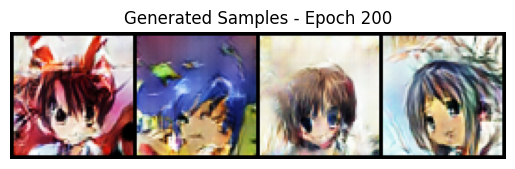

In [49]:
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples.cpu(), nrow=4, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch 200")
plt.show()

In [43]:
# pass real image into generator

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Load and preprocess the image
img_path = '/content/animeface-character-dataset/data/face_1254_484_37.png'
img = Image.open(img_path)

# Resize the image to match the expected input size of the CNN model
resize_transform = transforms.Resize((224, 224))
img_resized = resize_transform(img)

# Convert the image to a tensor and normalize it
to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_tensor = normalize_transform(to_tensor_transform(img_resized)).unsqueeze(0)

# Load a pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Set the model to evaluation mode
resnet.eval()

# Extract features from the image using the ResNet model
with torch.no_grad():
    features = resnet(img_tensor)

# Use a linear layer to reduce the number of channels to 128
linear_layer = torch.nn.Linear(in_features=features.size(1), out_features=128)
features_reduced = linear_layer(features.squeeze()).unsqueeze(-1).unsqueeze(-1)

# Add an extra dimension at the beginning
features_reduced = features_reduced.unsqueeze(0)

# Further processing or use of the feature map
print(features_reduced.shape)  # Output: torch.Size([1, 128, 1, 1])


torch.Size([1, 128, 1, 1])


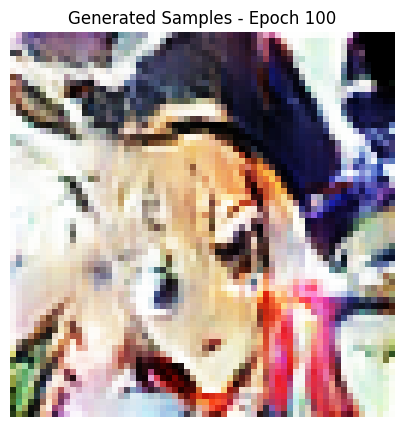

In [44]:
fake_samples = generator(features_reduced.to(device)).reshape(-1, 3, 64, 64)
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples.cpu(), nrow=4, padding=2, normalize=True)
plt.figure(figsize=(5, 5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()

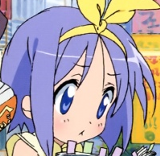

In [45]:
img